In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform

import os
import pickle
from IPython.display import display
from pathlib import Path

from classifier import resnet50

##  Load Model

In [2]:
def load_model():
    model = resnet50()
    model.load_state_dict(torch.load('../scripts/classifier.pth'))
    model.eval()
    return model

In [3]:
model = load_model()

## Get the data

In [4]:
class ParkingDataset(Dataset):
    def __init__(self, name=1, transform=None):
        img_dir = f'../../Data/parking{name}/test/'
        label_path = f'../../Data/labels/parking{name}_processed.txt'
        
        self.img_dir = img_dir
        self.imgs = os.listdir(img_dir)
        self.imgs.sort()
        with open(label_path, 'rb') as f:
            self.labels = pickle.load(f)
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = io.imread(self.img_dir + img_path)
        
        imgs = torch.zeros(len(self.labels), 3, 150, 150, dtype=torch.float)
        
        for i, label in enumerate(self.labels):
            temp = img[label[1]:label[3], label[0]:label[2]]
            if self.transform is not None:
                temp = self.transform(temp)
            imgs[i] = temp
        
        return imgs, img, self.labels

In [5]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, img):
        h, w = img.shape[:2]
        if isinstance(self.output_size, int):
            if h>w:
                new_h, new_w = self.output_size*h/w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size*w/h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(img, (new_h, new_w))
        return img

class ToTensor(object):
    def __call__(self, img):
        img = img.transpose((2, 0, 1))
        return torch.from_numpy(img)
    
scale = Rescale((150,150))
composed = transforms.Compose([Rescale((150,150)),
                               ToTensor()])

In [6]:
data_set = ParkingDataset(transform=composed)

In [7]:
len(data_set)

60

In [90]:
def get_preds(data):
    imgs, img, labels = data
    out = model(imgs)
    out = out.data.numpy()
    out = np.argmax(out, axis=1)
    return out, img, labels
preds, img, labels = get_preds(data_set[1])

In [91]:
def draw_results(preds, img, labels):
    imgcv = np.copy(img)
    for pred, label in zip(preds, labels):
        if pred == 0:
            cv2.rectangle(imgcv,
                          (label[0], label[1]), (label[2], label[3]),
                          (255,0,0),
                          2)
        else:
            cv2.rectangle(imgcv,
                          (label[0], label[1]), (label[2], label[3]),
                          (0,0,255),
                          2)
    plt.figure(figsize=(15,10))
    plt.imshow(imgcv)

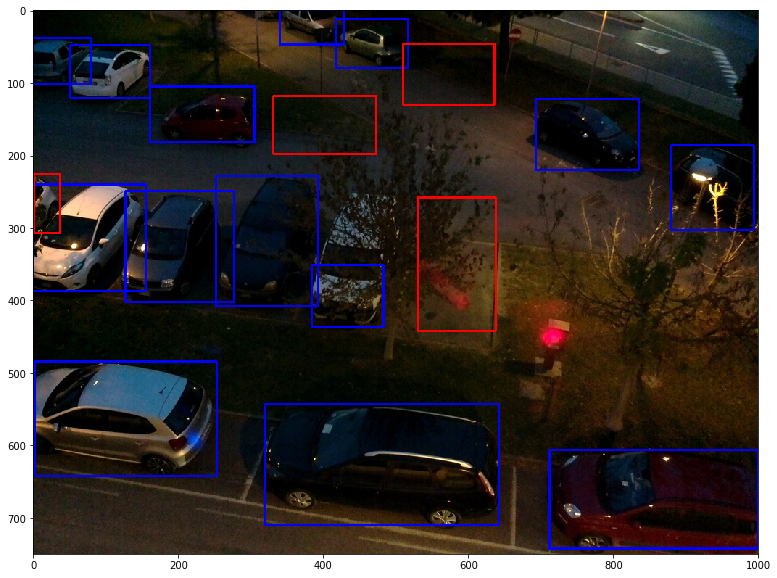

In [92]:
draw_results(preds, img, labels)